# Sentiment analysis of sci-kit learn's 20 newsgroups

This notebook performs a simple sentiment analysis using gensim's Word2Vec model as well as a recurrent neural network from keras. It uses the 20 newsgroups dataset which is imported from the sklearn dataset libraries. This dataset contains thousands of short text segments that each correspond to a specific topic. Here an estimator is created that is trained on these newsgroups and will be able to predict the topic of new text segments. In order to compute quicker only 4 topic categories will be used.  

## Loading the training data

In [3]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# Choose a few categories or all categories
categories=['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# Download the training and test sets.
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

## Prepare the text data 

Let us first take a look at the data.  

In [10]:
# The training data comes as a list of Strings. This shows an example of such a String.
documents = newsgroups_train.data

# Read the first entry.
documents[0]

"From: rych@festival.ed.ac.uk (R Hawkes)\nSubject: 3DS: Where did all the texture rules go?\nLines: 21\n\nHi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych\n\n======================================================================\nRycharde Hawkes\t\t\t\temail: rych@festival.ed.ac.uk\nVirtual Environment Laboratory\nDept. of Psychology\t\t\tTel  : +44 31 650 3426\nUniv. of Edinburgh\t\t\tFax  : +44 31 667 0150\n==============

We see that the text contains a lot of newlines "\n" which do not always carry much semantic meaning and we may therefore choose to remove them before creating an embedding. A quick way to do this is by using the `word_tokenize` method from the nltk package which tokenizes the text and throws away a lot of the objects that carry no semantic meaning. The text is also set to lower case such that there will be no difference between words containing and not containing uppercase letters. 

In [5]:
# Names of the targets (news groups)
target_names = newsgroups_train.target_names
target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [11]:
# Prepare the documents by setting them to lowercase and tokenize them. 
documents = [d.lower() for d in documents]
documents = [word_tokenize(d) for d in documents]

# See what the first entry now looks like. 
print(documents[0])

['from', ':', 'rych', '@', 'festival.ed.ac.uk', '(', 'r', 'hawkes', ')', 'subject', ':', '3ds', ':', 'where', 'did', 'all', 'the', 'texture', 'rules', 'go', '?', 'lines', ':', '21', 'hi', ',', 'i', "'ve", 'noticed', 'that', 'if', 'you', 'only', 'save', 'a', 'model', '(', 'with', 'all', 'your', 'mapping', 'planes', 'positioned', 'carefully', ')', 'to', 'a', '.3ds', 'file', 'that', 'when', 'you', 'reload', 'it', 'after', 'restarting', '3ds', ',', 'they', 'are', 'given', 'a', 'default', 'position', 'and', 'orientation', '.', 'but', 'if', 'you', 'save', 'to', 'a', '.prj', 'file', 'their', 'positions/orientation', 'are', 'preserved', '.', 'does', 'anyone', 'know', 'why', 'this', 'information', 'is', 'not', 'stored', 'in', 'the', '.3ds', 'file', '?', 'nothing', 'is', 'explicitly', 'said', 'in', 'the', 'manual', 'about', 'saving', 'texture', 'rules', 'in', 'the', '.prj', 'file', '.', 'i', "'d", 'like', 'to', 'be', 'able', 'to', 'read', 'the', 'texture', 'rule', 'information', ',', 'does', 'an

## Create the word embedding

With the documents tokenized we can use Gensim's Word2Vec method to train a wordembedding. The Word2Vec model is given four parameters in this case. The most interesting are `size` and `window`. `size` specifies the number of dimensions of the word vectors, here 200 is tried. `window` sets the size of the 

In [12]:
# Parameters used for the model.
vector_dim = 200
window = 3
min_count = 4
workers = 5

# Create Word2Vec instance and train it.
model = Word2Vec(
    documents,
    size=vector_dim,
    window=window,
    min_count=min_count,
    workers=workers)
model.train(documents, total_examples=len(documents), epochs=10)

# Grab the word vectors as a NumPy array. These will work as the embeddings in the neural network.
WordVectors = model[model.wv.vocab]

# vocab is a dictionary with the vocabulary defined by the Word2Vec model as keys.
vocab = model.wv.vocab

(5225484, 7873290)

We can check the word vectors and use common sense to evaluate how good they are. By using the `most_similar` method we find the words that lay closest in the vector space. For religion the closest words are 'faith', 'evil', 'islam' and 'atheism' all of which relate to religious discourse, so the model has found some correct semantic connections. 

In [24]:
model.wv.most_similar(positive="religion", topn=6)

[('faith', 0.7794517278671265),
 ('evil', 0.7537601590156555),
 ('islam', 0.7342736721038818),
 ('atheism', 0.7323622703552246),
 ('motto', 0.6956775188446045),
 ('statement', 0.69218909740448)]

## Tokens to indexed sequences

The keras embedding layer accepts input in the form of sequences of digits where each digit correspond to a particular row (or word vector) in the embedding matrix. Furthermore the sequences should be of a particular length. Here we choose `MAX_SEQUENCE_LENGTH = 50` in the hope that training will run quickly and that only the first 50 words are needed in order to determine the topic. Keras provides the function `pad_sequences` which pads any text shorter than 50 words with zeros and truncates those that are longer such that they fit the desired sequence length.

In [25]:
# Change the documents into lists of integers where each integer is the index of the word in the embedding.
# The lists are sequences must all have the same length, MAX_SEQUENCE_LENGTH, so those that are too long
# are truncated while those that are too short are padded with zeros.
MAX_SEQUENCE_LENGTH = 50

word_index = {t: i for i,t in enumerate(list(vocab))}
sequences = [[word_index.get(t,0) for t in document] for document in documents]
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre", truncating="post")

# Inspect the first entry again.
X_train[0]

array([ 0,  1,  0,  2,  0,  3,  4,  0,  5,  6,  1,  7,  1,  8,  9, 10, 11,
       12, 13, 14, 15, 16,  1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29,  3, 30, 10, 31, 32, 33,  0, 34,  5, 35, 28, 36, 37, 23],
      dtype=int32)

Before setting up the neural network we prepare the test data and the labels.

In [15]:
# Reference the test data as test_docs and test_label.
test_docs = newsgroups_test.data
test_label = newsgroups_test.target

# Lowercase and tokenize.
test_docs = [d.lower() for d in test_docs]
test_docs = [word_tokenize(d) for d in test_docs]

# Change the words to integers and pad/truncate the sequences.
test_sequences = [[word_index.get(t,0) for t in document] for document in test_docs]
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre", truncating="post")

# Choose fitting names for the targets.
y_train = newsgroups_train.target
y_test = test_label

## Recurrent Neural Network

This network will be very short and consist only of 4 layers. An embedding layer, an LSTM, a dense layer and an output layer. 

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Dropout

k_model = Sequential()

k_model.add(Embedding(len(vocab), vector_dim, weights=[WordVectors], 
                      input_length=MAX_SEQUENCE_LENGTH, trainable=False))
k_model.add(LSTM(vector_dim, dropout=0.2, return_sequences=True))
#k_model.add(LSTM(vector_dim, return_sequences=True))
k_model.add(Flatten())
k_model.add(Dense(512, activation=tf.nn.relu))
k_model.add(Dense(len(target_names), activation=tf.nn.softmax))

k_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = k_model.fit(X_train, y_train, epochs=6, batch_size=32, verbose = 1, validation_data=[X_test, y_test])

Train on 2034 samples, validate on 1353 samples
Epoch 1/6
2034/2034 [==============================] - 264s 130ms/step - loss: 0.8680 - acc: 0.6529 - val_loss: 0.6455 - val_acc: 0.7465
Epoch 2/6
2034/2034 [==============================] - 243s 119ms/step - loss: 0.3827 - acc: 0.8545 - val_loss: 0.6681 - val_acc: 0.7679
Epoch 3/6
2034/2034 [==============================] - 202s 99ms/step - loss: 0.2254 - acc: 0.9105 - val_loss: 0.7447 - val_acc: 0.7494
Epoch 4/6
2034/2034 [==============================] - 234s 115ms/step - loss: 0.1166 - acc: 0.9602 - val_loss: 0.7631 - val_acc: 0.7724
Epoch 5/6
2034/2034 [==============================] - 213s 105ms/step - loss: 0.0662 - acc: 0.9798 - val_loss: 0.8641 - val_acc: 0.7635
Epoch 6/6
2034/2034 [==============================] - 211s 104ms/step - loss: 0.0631 - acc: 0.9789 - val_loss: 0.8471 - val_acc: 0.7731


## Conclusion

The network quickly starts to overfit due to the tiny number of training examples which is far below the total number of parameters. One possibility is to use a premade embedding vector training on millions of data points, which would improve the embedding.  

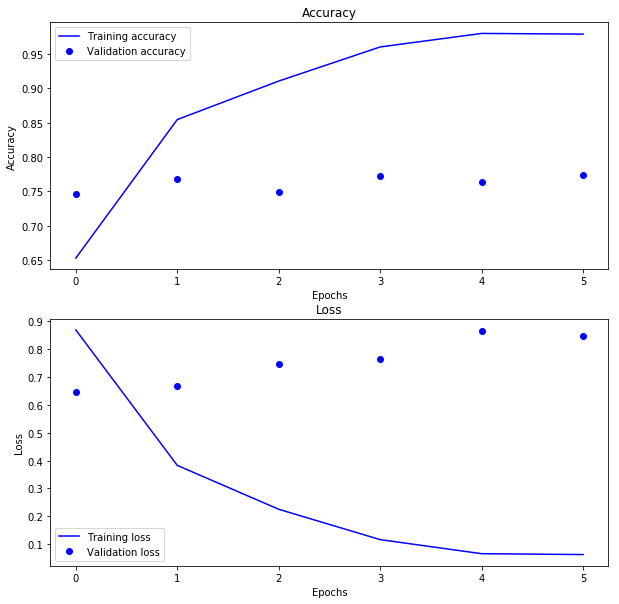

In [35]:
# Plot the accuracy and loss.
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,10))

plt.subplot(211)
plt.plot(list(range(6)), acc, 'b', label="Training accuracy")
plt.plot(list(range(6)), val_acc, 'bo', label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(212)
plt.plot(list(range(6)), loss, 'b', label="Training loss")
plt.plot(list(range(6)), val_loss, 'bo', label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()